In [2]:
import torch
import torch.nn as nn
import torch.optim as opt
from model.sffnet import USFFNet
from utils.evaluate import Evaluate

from torch.utils.data import DataLoader, TensorDataset
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('./logs')
from torchvision import utils as vutils
import os
import random
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda:0'
batch_size = 128
stride = 1
window_size = 150

path = './datasets/SOC/0degC'
train_list = ['589_Mixed1.csv', '589_Mixed2.csv', '590_Mixed4.csv', '590_Mixed5.csv', '590_Mixed6.csv', '590_Mixed7.csv']
test_list = ['590_Mixed8.csv']

In [4]:
from utils.build_dataloader import get_dataloder
train_loader, test_loader = get_dataloder(path, window_size, stride, train_list, test_list, batch_size, device)
vali_loader = test_loader

loading data...


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


In [5]:
test_ratio = 1
epoches = 20
weight_decay = 1e-4
learning_rate = 5e-4
loss_funcation = nn.MSELoss()
evaluater = Evaluate(path.split('/')[1], 'Ablation', test_ratio)
block_num = 5
feature_num = 3

spa_ks_list = [3, 5, 7, 7, 7]
fre_ks_list = [3, 5, 7, 7, 7]
fus_ks_list = [3, 3, 7, 7, 7]
mid_channel_list = [32, 16, 8, 4, 4]


In [24]:
import torch
import math
import torch.nn.init as init
import torch.nn as nn
import torch.fft as fft
from model.uncertainty_head import UncertaintyHead
from model.basic_module import *
from Embed import *
from torchvision import utils as vutils
import time


class SpatialFlow(nn.Module):

    def __init__(self, window_size, feature_num, mid_channel, kernel_size):
        super(SpatialFlow, self).__init__()
        padding = int(kernel_size//2)
        self.up_conv1 = nn.Conv1d(feature_num  ,feature_num*2,kernel_size,1,padding)
        self.up_conv2 = nn.Conv1d(feature_num*2,feature_num*4,kernel_size,1,padding)

        self.c_conv = nn.Conv1d(feature_num*4, feature_num*4,kernel_size,1,padding)

        self.down_conv2 = nn.Conv1d(feature_num*4,feature_num*2,kernel_size,1,padding)
        self.down_conv1 = nn.Conv1d(feature_num*2,feature_num  ,kernel_size,1,padding)
        # self.icb = ICB(feature_num,mid_channel)
        # up_sampling

        # down_sampling

        self.Spa_CNN = nn.Sequential(nn.Conv1d(feature_num, mid_channel, kernel_size, 1, padding),
                                      nn.ReLU(),
                                      nn.Conv1d(mid_channel, feature_num, kernel_size, 1, padding),
                                      )
        self.act = nn.ReLU()


    def forward(self, x):
        Spa_feature = self.Spa_CNN(x)

        return Spa_feature


class FrequencyFlow(nn.Module):

    def __init__(self, window_size, feature_num, mid_channel, kernel_size):
        super(FrequencyFlow, self).__init__()
        padding = int(kernel_size//2)
        self.pha_process = nn.Sequential(nn.Conv1d(feature_num, mid_channel, kernel_size, 1, padding), nn.ReLU(),
                                        nn.Conv1d(mid_channel, feature_num, kernel_size, 1, padding))
        self.amp_process = nn.Sequential(nn.Conv1d(feature_num, mid_channel, kernel_size, 1, padding), nn.ReLU(),
                                        nn.Conv1d(mid_channel, feature_num, kernel_size, 1, padding))

    def make_complex(self, phase, amplitude):
        real = amplitude * torch.cos(phase)
        im = amplitude * torch.sin(phase)
        complex_num = torch.complex(real, im)
        return complex_num

    def forward(self, x):
        frequency = fft.fft(x, dim=2, norm='backward')
        phase = torch.angle(frequency)
        magnitude = torch.abs(frequency)
        refine_phase = self.pha_process(phase)
        refine_magnitude = self.amp_process(magnitude)
        refine_spatial = self.make_complex(refine_phase, refine_magnitude)
        Fre_feature = torch.abs(fft.ifft(refine_spatial, dim=2, norm='backward'))
        return Fre_feature


class FusionBlock(nn.Module):

    def __init__(self, window_size, kernel_size, feature_num, r):
        super(FusionBlock, self).__init__()
        self.SA = SpatialAttention(kernel_size)
        self.CA = ChannelAttention(feature_num, r)


    def forward(self, fre_feature, spa_feature):
        spatial_refine_feature = self.SA(fre_feature - spa_feature)
        channel_refine_feature = self.CA(fre_feature + spa_feature)
        return channel_refine_feature + spatial_refine_feature

class ICB(nn.Module):
    def __init__(self, in_features, hidden_features, drop=0.7):
        super().__init__()
        self.conv1 = nn.Conv1d(in_features, hidden_features, 1)
        self.conv2 = nn.Conv1d(in_features, hidden_features, 3, 1, padding=1)
        self.conv3 = nn.Conv1d(hidden_features, in_features, 1)
        self.drop = nn.Dropout(drop)
        self.act = nn.ReLU()
        self.bn = nn.BatchNorm1d(in_features)

    def forward(self, x):
        # x = x.transpose(1, 2)
        x1 = self.conv1(x)
        x1_1 = self.act(x1)
        x1_2 = self.drop(x1_1)

        x2 = self.conv2(x)
        x2_1 = self.act(x2)
        x2_2 = self.drop(x2_1)

        out1 = x1 * x2_2
        out2 = x2 * x1_2

        out = self.conv3(out1 + out2)

        return out




class CRU(nn.Module):

    def __init__(self, window_size, kernel_size, feature_num, r):
        super(CRU, self).__init__()
        self.vc_channel = 2
        self.t_channel = 1
        ratio = 2
        self.vc_conv1   = nn.Conv1d(self.vc_channel,self.vc_channel*ratio,kernel_size)
        self.t_conv1 = nn.Conv1d(self.t_channel,self.t_channel*ratio,kernel_size)

        self.vc_conv2 =nn.Conv1d(self.vc_channel*ratio,self.vc_channel,1)
        self.t_conv2 = nn.Conv1d(self.t_channel*ratio,self.t_channel,1)

        self.vc_conv3 =nn.Conv1d(self.vc_channel*ratio,self.vc_channel,kernel_size)
        self.t_conv3 = nn.Conv1d(self.t_channel*ratio,self.t_channel,kernel_size)

    def forward(self, x):
        vc,t = torch.split(x,[self.vc_channel,self.t_channel],dim=1)
        vc = self.vc_conv(vc)
        t  = self.t_conv(t)

        vc = self.vc_conv2(vc) + self.vc_conv3(vc)
        t = self.t_conv2(t) + self.vc_conv3(t)

        feature = torch.cat([vc,t],dim=1)

        return feature + x

class PAIFILTER(nn.Module):

    def __init__(self,hidden_size,seq_len):
        super(PAIFILTER, self).__init__()
        self.seq_len = seq_len
        self.pred_len = 1
        self.scale = 0.02

        self.embed_size = self.seq_len
        self.hidden_size = hidden_size

        self.w = nn.Parameter(self.scale * torch.randn(3, self.embed_size))

        self.fc = nn.Sequential(
            nn.Linear(self.embed_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.pred_len)
        )
        self.softmx = nn.Softmax(dim=1)


    def circular_convolution(self, x, w):
        x = torch.fft.rfft(x, dim=2, norm='ortho')
        w = torch.fft.rfft(w, dim=1, norm='ortho')
        y = x * w
        out = torch.fft.irfft(y, n=self.embed_size, dim=2, norm="ortho")
        return out

    def forward(self, x):
        x = self.circular_convolution(x, self.w.to(x.device))  # B, N, D
        x = self.fc(x)
        x = self.softmx(x)

        return x


class SFFBlock(nn.Module):

    def __init__(self, window_size, feature_num, mid_channel, spa_ks, fre_ks, fus_ks, r, fb, sf, ff):
        super(SFFBlock, self).__init__()
        self.fb, self.sf, self.ff = fb, sf, ff
        if fb is True:
            self.FB = FusionBlock(window_size, fus_ks, feature_num, r)
        if sf is True:
            self.SF = SpatialFlow(window_size, feature_num, mid_channel, spa_ks)
        if ff is True:
            self.FF = FrequencyFlow(window_size, feature_num, mid_channel, fre_ks)

        self.ffn = nn.Linear(feature_num*2,feature_num)
        self.act = nn.Sigmoid()
        self.Spa_feature = None
        self.Fre_feature = None
        self.Spa_feature_grad = None
        self.Fre_feature_grad = None

    def forward(self, x):
        feature = 0
        # 清空上次保存的特征
        self.Spa_feature, self.Fre_feature = None, None

        if self.sf is True:
            Spa_feature = self.SF(x)
            self.Spa_feature = Spa_feature
            feature += Spa_feature
            if self.training and Spa_feature.requires_grad:
                Spa_feature.register_hook(lambda grad: setattr(self, 'Spa_feature_grad', grad))


        if self.ff is True:
            Fre_feature = self.FF(x)
            self.Fre_feature = Fre_feature
            feature += Fre_feature
            if self.training and Fre_feature.requires_grad:
                Fre_feature.register_hook(lambda grad: setattr(self, 'Fre_feature_grad', grad))

        # ... [保持原有融合逻辑] ...
        # feature = Spa_feature
        # feature = Fre_feature
        # feature = Fre_feature + Spa_feature
        # feature = self.ffn(torch.concat([Spa_feature , Fre_feature],dim=1).transpose(2,1)).transpose(1,2)
        # feature = self.FB(Spa_feature,Fre_feature)
        # feature = self.icb(torch.concat([Spa_feature , Fre_feature],dim=1))

        return feature+x


class USFFNet(nn.Module):

    def __init__(self, num_block, feature_num, window_size,stride, mid_channel_list, spa_ks_list, fre_ks_list, fus_ks_list):
        super(USFFNet, self).__init__()
        self.SFFBlock = nn.Sequential()
        for i in range(num_block):
             self.SFFBlock.add_module('SFFBlock'+str(i), SFFBlock(window_size, feature_num, mid_channel_list[i], spa_ks_list[i], fre_ks_list[i], fus_ks_list[i], 2, True, True, True))
        self.CNNI = nn.Sequential(nn.Conv1d(feature_num, 1, 3, 1, 1))
        self.Uncertainty_Head = UncertaintyHead(window_size,stride)
        # self.icb = ICB(feature_num, feature_num)
        self.embedding = DataEmbedding(feature_num,feature_num)

        self.paifilter = PAIFILTER(hidden_size=50,seq_len=window_size)

    def forward(self, x):

        embeded_x = self.embedding(x)
        # print(feature.shape)
        # feature, weight  = self.Adaptive_Spectral_Block(embeded_x)
        # print(feature.shape,sum(freq_mask))
        # print(feature.shape)

        weight = self.paifilter(embeded_x)

        # feature = self.SFFBlock(feature + x )
        feature = self.SFFBlock(weight * embeded_x + x)
        # feature = self.CNNI(feature)
        # feature = self.icb(feature)
        #

        feature = feature.reshape(feature.shape[0], feature.shape[1]*feature.shape[2])

        gamma, nu, alpha, beta = self.Uncertainty_Head.forward(feature)
        return gamma, nu, alpha, beta


In [9]:
model = USFFNet(block_num, feature_num, window_size,stride, mid_channel_list, spa_ks_list, fre_ks_list, fus_ks_list).to(device)

optimizer = opt.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
evaluater.record_param_setting(window_size, stride, batch_size, learning_rate, weight_decay, model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)


In [10]:
lambda_coef = []
train_loss = []
vaild_loss = []

In [11]:
for epoch in range(epoches):
    model.train()
    epoch_loss = 0
    print('epoch: '+str(epoch))
    for x, y in tqdm(train_loader):
        # train
        gamma, nu, alpha, beta = model.forward(x)
        loss, nig_loss, nig_regularization = model.Uncertainty_Head.get_loss(y, gamma, nu, alpha, beta)

        loss = loss_funcation(gamma, y)+loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.Uncertainty_Head.hyperparams_update(nig_regularization)
        # print(gamma.shape)
        _loss = loss_funcation(gamma, y)
        epoch_loss += _loss.item()

    epoch_loss /= train_loader.__len__()
#     writer.add_scalar("Loss/train",epoch_loss,epoch)
    lambda_coef.append(model.Uncertainty_Head.lambda_coef.detach().cpu().numpy())
    train_loss.append(epoch_loss)
    print('trainning_loss = '+str(epoch_loss))
    if epoch%test_ratio == 0:
        model.eval()
        epoch_loss = 0
        for x, y in test_loader:
            gamma, nu, alpha, beta = model.forward(x)
            gamma = torch.cat((gamma[:5], (gamma[:-5] + gamma[1:-4]  + gamma[2:-3] + gamma[3:-2] + gamma[4:-1]) / 5), dim=0)
            _loss = loss_funcation(gamma, y)
            epoch_loss += _loss.item()
        epoch_loss /= test_loader.__len__()
#         writer.add_scalar('Loss/vali',epoch_loss,epoch)

        vaild_loss.append(epoch_loss)
        print('testing_loss = '+str(epoch_loss))

    # if early_stopping.early_stop:
    #     print("Early stopping")
    #    break
    evaluater.visualize(train_loss, vaild_loss, model, None)

epoch: 0


100%|██████████| 2810/2810 [00:43<00:00, 64.48it/s]


trainning_loss = 0.0019057066955361715
testing_loss = 0.0010268736044125985
Validation loss decreased (1.000000 --> 0.001027).  Saving model ...
epoch: 1


100%|██████████| 2810/2810 [00:40<00:00, 68.77it/s]


trainning_loss = 0.0010717689251697876
testing_loss = 0.001595748086799422
epoch: 2


100%|██████████| 2810/2810 [00:47<00:00, 59.69it/s]


trainning_loss = 0.0008139449724280424
testing_loss = 0.0009080636334484846
Validation loss decreased (0.001027 --> 0.000908).  Saving model ...
epoch: 3


100%|██████████| 2810/2810 [00:45<00:00, 62.19it/s]


trainning_loss = 0.0006478862114021973
testing_loss = 0.0008996263362762387
Validation loss decreased (0.000908 --> 0.000900).  Saving model ...
epoch: 4


100%|██████████| 2810/2810 [00:41<00:00, 67.99it/s]


trainning_loss = 0.0005811482141050427
testing_loss = 0.0009122659326541961
epoch: 5


100%|██████████| 2810/2810 [00:41<00:00, 67.61it/s]


trainning_loss = 0.000572234559875666
testing_loss = 0.000771562229687942
Validation loss decreased (0.000900 --> 0.000772).  Saving model ...
epoch: 6


100%|██████████| 2810/2810 [00:41<00:00, 66.96it/s]


trainning_loss = 0.0005711340040939585
testing_loss = 0.0010260508527203589
epoch: 7


100%|██████████| 2810/2810 [00:45<00:00, 61.96it/s]


trainning_loss = 0.0006704569579532131
testing_loss = 0.0005642254404366674
Validation loss decreased (0.000772 --> 0.000564).  Saving model ...
epoch: 8


100%|██████████| 2810/2810 [00:46<00:00, 60.48it/s]


trainning_loss = 0.0005733335645474971
testing_loss = 0.0007336105915619421
epoch: 9


100%|██████████| 2810/2810 [00:45<00:00, 61.57it/s]


trainning_loss = 0.0005347765804420878
testing_loss = 0.0005939944429363376
epoch: 10


100%|██████████| 2810/2810 [00:42<00:00, 66.75it/s]


trainning_loss = 0.00048528552571977773
testing_loss = 0.0006298065430452566
epoch: 11


100%|██████████| 2810/2810 [00:46<00:00, 60.52it/s]


trainning_loss = 0.0004559499595966356
testing_loss = 0.0006675739160654945
epoch: 12


100%|██████████| 2810/2810 [00:48<00:00, 58.38it/s]


trainning_loss = 0.0004282304190450971
testing_loss = 0.0005394907656180023
Validation loss decreased (0.000564 --> 0.000539).  Saving model ...
epoch: 13


100%|██████████| 2810/2810 [00:46<00:00, 61.01it/s]


trainning_loss = 0.00041422522736086055
testing_loss = 0.0005878968613807408
epoch: 14


100%|██████████| 2810/2810 [00:44<00:00, 63.12it/s]


trainning_loss = 0.0003990776080793943
testing_loss = 0.0006172892235947062
epoch: 15


100%|██████████| 2810/2810 [00:43<00:00, 65.32it/s]


trainning_loss = 0.00039150430582148054
testing_loss = 0.0008765220307810416
epoch: 16


100%|██████████| 2810/2810 [00:41<00:00, 67.49it/s]


trainning_loss = 0.0003799351838136049
testing_loss = 0.000834771356568019
epoch: 17


100%|██████████| 2810/2810 [00:46<00:00, 60.69it/s]


trainning_loss = 0.0003706619811268752
testing_loss = 0.0006204312217539777
epoch: 18


100%|██████████| 2810/2810 [00:45<00:00, 61.31it/s]


trainning_loss = 0.0003647316332982714
testing_loss = 0.0007244934432987173
epoch: 19


100%|██████████| 2810/2810 [00:43<00:00, 64.21it/s]


trainning_loss = 0.0003643924986456398
testing_loss = 0.0007187064576136074


<Figure size 640x480 with 0 Axes>

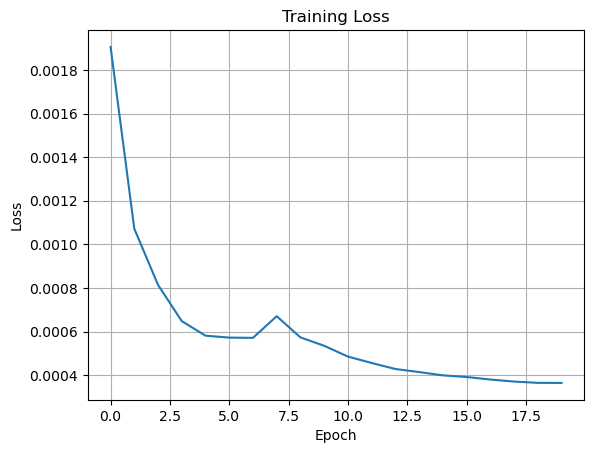

In [29]:
# train_loss plot
import matplotlib.pyplot as plt
plt.figure()
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.plot(range(len(train_loss)), train_loss)
plt.show()

In [17]:
exp_path = 'result/datasets/Ablation/exp0'
model = torch.load(os.path.join(exp_path, 'model.pkl')).to(device)

In [18]:
def analyze_feature_norms(model, dataloader):
    """分析时域/频域特征的相对幅度"""
    model.eval()  # 评估模式
    spa_norms, fre_norms = [], []
    block_spa_norms = [[] for _ in model.SFFBlock]
    block_fre_norms = [[] for _ in model.SFFBlock]

    with torch.no_grad():
        for x, y in dataloader:
            _ = model(x)  # 前向传播
            # 收集所有block的特征范数
            for i, block in enumerate(model.SFFBlock):
                if block.Spa_feature is not None:
                    spa_norm = torch.norm(block.Spa_feature, p='fro').item()
                    block_spa_norms[i].append(spa_norm)
                    spa_norms.append(spa_norm)

                if block.Fre_feature is not None:
                    fre_norm = torch.norm(block.Fre_feature, p='fro').item()
                    block_fre_norms[i].append(fre_norm)
                    fre_norms.append(fre_norm)

    # 整体统计
    print(f"全局时域特征平均范数: {np.mean(spa_norms):.4f} ± {np.std(spa_norms):.4f}")
    print(f"全局频域特征平均范数: {np.mean(fre_norms):.4f} ± {np.std(fre_norms):.4f}")
    print(f"时域/频域范数比: {np.mean(spa_norms)/np.mean(fre_norms):.4f}")

    # 各block统计
    for i in range(len(block_spa_norms)):
        if block_spa_norms[i]:
            spa_mean = np.mean(block_spa_norms[i])
            fre_mean = np.mean(block_fre_norms[i])
            print(f"Block {i}: 时域={spa_mean:.4f}, 频域={fre_mean:.4f}, 比例={spa_mean/fre_mean:.4f}")

    return spa_norms, fre_norms

In [19]:
def analyze_feature_gradients(model, dataloader, criterion):
    """分析特征在反向传播中的重要性"""
    model.train()  # 训练模式（启用梯度）
    spa_grads, fre_grads = [], []
    block_spa_grads = [[] for _ in model.SFFBlock]
    block_fre_grads = [[] for _ in model.SFFBlock]

    for x, y in dataloader:
        model.zero_grad()
        gamma, nu, alpha, beta = model(x)
        loss = criterion(gamma, nu, alpha, beta, y)
        loss.backward()

        # 收集梯度信息
        for i, block in enumerate(model.SFFBlock):
            if block.Spa_feature_grad is not None:
                grad_norm = torch.norm(block.Spa_feature_grad, p='fro').item()
                block_spa_grads[i].append(grad_norm)
                spa_grads.append(grad_norm)

            if block.Fre_feature_grad is not None:
                grad_norm = torch.norm(block.Fre_feature_grad, p='fro').item()
                block_fre_grads[i].append(grad_norm)
                fre_grads.append(grad_norm)

    # 整体统计
    print(f"时域特征平均梯度范数: {np.mean(spa_grads):.4f} ± {np.std(spa_grads):.4f}")
    print(f"频域特征平均梯度范数: {np.mean(fre_grads):.4f} ± {np.std(fre_grads):.4f}")
    print(f"时域/频域梯度比: {np.mean(spa_grads)/np.mean(fre_grads):.4f}")

    # 各block统计
    for i in range(len(block_spa_grads)):
        if block_spa_grads[i]:
            spa_grad = np.mean(block_spa_grads[i])
            fre_grad = np.mean(block_fre_grads[i])
            print(f"Block {i}: 时域梯度={spa_grad:.4f}, 频域梯度={fre_grad:.4f}, 比例={spa_grad/fre_grad:.4f}")

    return spa_grads, fre_grads

In [26]:
model = USFFNet(block_num, feature_num, window_size,stride, mid_channel_list, spa_ks_list, fre_ks_list, fus_ks_list).to(device)
models = torch.load(os.path.join(exp_path, 'model.pkl')).to(device)
from model.uncertainty_head import UncertaintyHead
# 定义损失函数（假设使用负对数似然）
def criterion(gamma, nu, alpha, beta, y):
    # 实现正态逆伽马分布的NLL损失
    # [根据您的实际损失函数实现]
    nll_loss ,_,_= model.Uncertainty_Head.get_loss(y, gamma, nu, alpha, beta)
    return nll_loss

# 执行分析
print("=== 特征范数分析 ===")
spa_norms, fre_norms = analyze_feature_norms(models, vali_loader)

print("\n=== 梯度重要性分析 ===")
spa_grads, fre_grads = analyze_feature_gradients(models, train_loader, criterion)


=== 特征范数分析 ===
全局时域特征平均范数: 60.3993 ± 36.8461
全局频域特征平均范数: 31.1333 ± 8.6686
时域/频域范数比: 1.9400
Block 0: 时域=114.8999, 频域=32.9905, 比例=3.4828
Block 1: 时域=43.2653, 频域=34.6235, 比例=1.2496
Block 2: 时域=57.6840, 频域=36.8561, 比例=1.5651
Block 3: 时域=40.5001, 频域=31.3335, 比例=1.2926
Block 4: 时域=45.6469, 频域=19.8627, 比例=2.2981

=== 梯度重要性分析 ===
时域特征平均梯度范数: 0.1353 ± 1.2398
频域特征平均梯度范数: 0.1353 ± 1.2398
时域/频域梯度比: 1.0000
Block 0: 时域梯度=0.2435, 频域梯度=0.2435, 比例=1.0000
Block 1: 时域梯度=0.1848, 频域梯度=0.1848, 比例=1.0000
Block 2: 时域梯度=0.0945, 频域梯度=0.0945, 比例=1.0000
Block 3: 时域梯度=0.0820, 频域梯度=0.0820, 比例=1.0000
Block 4: 时域梯度=0.0718, 频域梯度=0.0718, 比例=1.0000
